In [36]:
# Librairies & paramètres
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import lib
import squarify

param = {

    # Direction vers lmes fichiers SRA
    "GeoSRA DIR IN" :"../../data/raw/geo-sra-ecological-1604.parquet.gzip",
    "GeoSRA DIR OUT":"../../data/processed/geosra_clean.parquet.gzip",
    "Country DIR"   :"naturalearth_lowres",

    # Dates pour les histogrammes
    "Start Year"    :2010,
    "End Year"      :2024, 

    # Taille des points
    "Dot Size"      :1,

    # Seuil minimal de précision des coordonées
    "Seuil LonLatAc":2,

    # Couleurs
    "Basic Color"   :["gray"],
    "Dot Color"     :"maroon",
    "GeoTypes Color":['darkgreen','darkblue','darkorange','darkred'],
    "Binary Color"  :['lightcoral','lightgreen'],
    "TreeMap Color" :["black", "red", "blue", "orange", "green"]

}

In [30]:
# Ouverture des fichiers
geosra_pd = pd.read_parquet(param["GeoSRA DIR IN"])
file = gpd.datasets.get_path(param["Country DIR"])
countries = gpd.read_file(file)
geosra_pd.head()

,bioproject,acc,organism,assay_type,instrument,librarylayout,libraryselection,librarysource,geo_loc_name_country_calc,geo_loc_name_country_continent_calc,...,latitude,longitude,latitude_precision,longitude_precision,has_latlon,rg_country_code,rg_city,rg_country,gc_continent,gc_continent_code
123,SRR17464453,SRR17464453,metagenome,WGS,DNBSEQ-T7,PAIRED,RANDOM,METAGENOMIC,China,Asia,...,32.0300,118.4600,2.0,1.0,True,CN,Jiangpu,China,Asia,AS
124,SRR26717880,SRR26717880,chicken gut metagenome,WGS,DNBSEQ-T7,PAIRED,RANDOM,METAGENOMIC,China,Asia,...,30.3000,103.0000,1.0,1.0,True,CN,Muping,China,Asia,AS
125,SRR26864360,SRR26864360,mouse gut metagenome,WGS,DNBSEQ-T7,PAIRED,RANDOM,METAGENOMIC,China,Asia,...,36.0000,105.0000,1.0,1.0,True,CN,Huishi,China,Asia,AS
126,SRR28250737,SRR28250737,metagenome,RNA-Seq,DNBSEQ-T7,PAIRED,RANDOM PCR,METATRANSCRIPTOMIC,Kenya,Africa,...,-1.1800,34.6300,2.0,1.0,True,KE,Kihancha,Kenya,Africa,AF
128,ERR9321740,ERR9321740,human gut metagenome,WGS,DNBSEQ-T7,PAIRED,RANDOM,METAGENOMIC,Hong Kong,Asia,...,22.3193,114.1694,4.0,1.0,True,HK,Kowloon,Hong Kong,Asia,AS


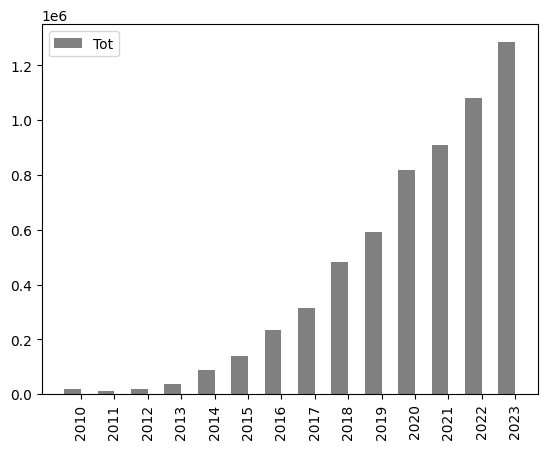

In [32]:
# Création de la colonne release_year et Histogramme par années
geosra_pd["release_year"] = geosra_pd["releasedate"].dt.year
datas = []
for year in range(2010,2024):
    data_year = {"Tot": len(geosra_pd[geosra_pd["release_year"] == year])}
    datas.append(data_year)
df = pd.DataFrame(datas,index=[year for year in range(param["Start Year"],param["End Year"])])
lib.hist(df, width_bar = 0.5, colors=param["Basic Color"])

C:\Users\thillairet\AppData\Local\Temp\ipykernel_15200\3997921249.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_latlon['geometry'] = [Point(xy) for xy in zip(df_latlon['longitude'],df_latlon['latitude'])]


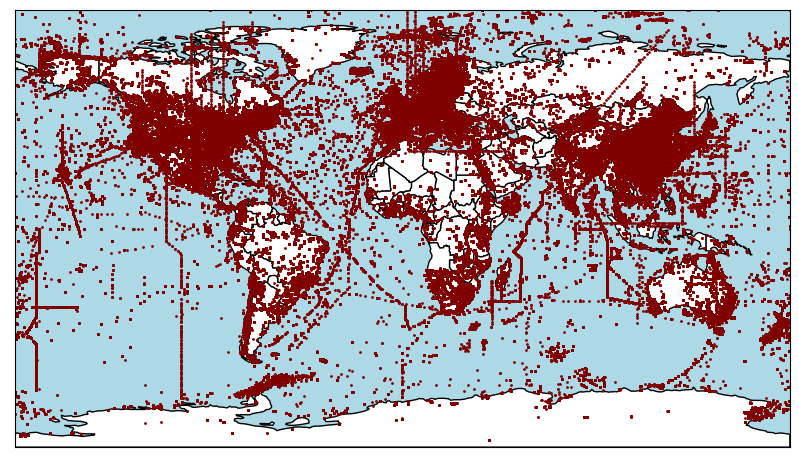

In [25]:
# Cartographie de la totalité de GeoSRA
df_latlon = geosra_pd[geosra_pd['has_latlon'] == True]
df_latlon['geometry'] = [Point(xy) for xy in zip(df_latlon['longitude'],df_latlon['latitude'])]
gdf_latlon = gpd.GeoDataFrame(df_latlon, geometry='geometry')
gdf_latlon.crs = 'EPSG:4326'

fig, ax = plt.subplots(figsize=(10, 6))
countries.plot(ax=ax ,edgecolor='black', facecolor='white')
gdf_latlon.plot(color=param["Dot Color"], ax=ax, markersize=param["Dot Size"])
ax.set_facecolor('lightblue')
ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

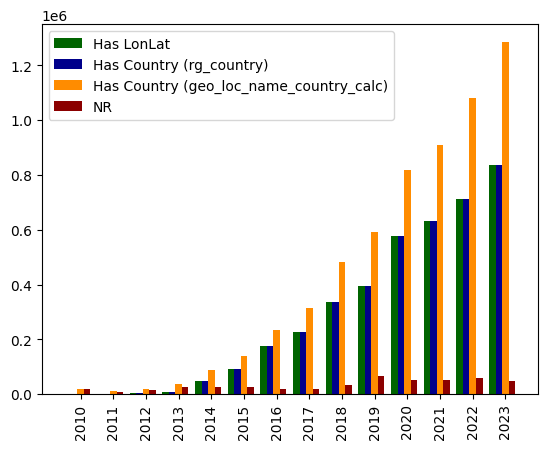

In [33]:
# Répartition des types de géoréférencement par années
datas = []
for year in range(param["Start Year"],param["End Year"]):
    data_year = geosra_pd[geosra_pd["release_year"] == year]
    data_lonlat = len(data_year[data_year["has_latlon"] == True])
    data_country_1 = len(data_year["geo_loc_name_country_calc"].notnull())
    data_country_2 = len(data_year[data_year["rg_country"] != ''])
    data_nothing = len(data_year[(data_year["has_latlon"].isnull()) & (data_year["geo_loc_name_country_calc"].isnull()) & (data_year["rg_country"] == '')])
    datas.append({"Has LonLat":data_lonlat,"Has Country (rg_country)":data_country_2,"Has Country (geo_loc_name_country_calc)":data_country_1,"NR":data_nothing})
df = pd.DataFrame(datas,index=[year for year in range(param["Start Year"],param["End Year"])])

lib.hist(df, width_bar=0.2, colors=param["GeoTypes Color"])

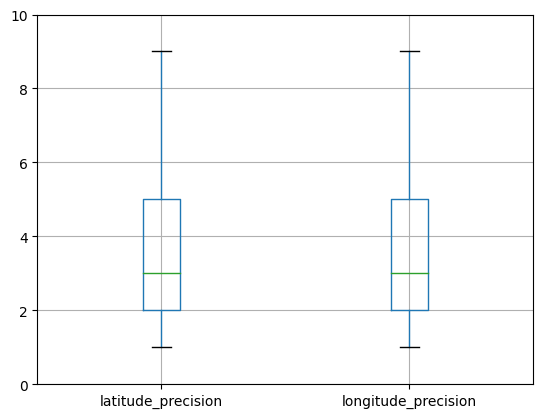

In [34]:
# Répartition de la précision des coorodnées
def nombre_decimales(nombre):
    if nombre == np.NaN:
        return np.NaN
    chaine = str(nombre)
    index_point = chaine.find('.')
    if index_point == -1:
        return np.NaN
    return len(chaine) - index_point - 1
geosra_pd["latitude_precision"] = geosra_pd["latitude"].apply(nombre_decimales)
geosra_pd["longitude_precision"] = geosra_pd["longitude"].apply(nombre_decimales)

selected_data = geosra_pd[["latitude_precision","longitude_precision"]]    
selected_data.boxplot(showfliers=False)
plt.yticks([y for y in range(0,12,2)])
plt.show()

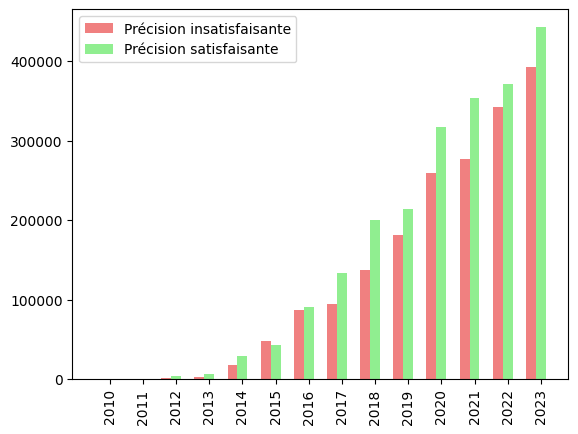

In [37]:
# Calcul des imprécisions par années
thr = param["Seuil LonLatAc"]
datas = []
for year in range(param["Start Year"],param["End Year"]):
    data_year = geosra_pd[geosra_pd["release_year"] == year]
    data_insat = len(data_year[(data_year["latitude_precision"] <= thr) | (data_year["longitude_precision"] <= thr)])
    data_sat = len(data_year[(data_year["latitude_precision"] > thr) & (data_year["longitude_precision"] > thr)])
    datas.append({"Précision insatisfaisante":data_insat,"Précision satisfaisante":data_sat})
df = pd.DataFrame(datas,index=[year for year in range(param["Start Year"],param["End Year"])])

lib.hist(df, width_bar=0.3, colors=param["Binary Color"])

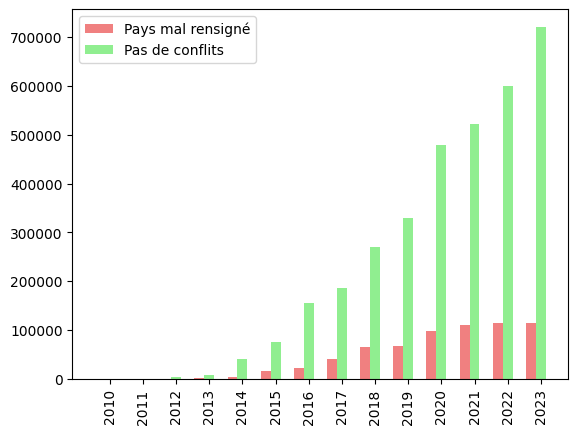

In [38]:
# Calcul des conflits de pays par années
if 'conflict_country' in geosra_pd.columns:
    geosra_pd.drop('conflict_country', axis=1, inplace=True)
join = gdf_latlon.sjoin(countries, how='left', predicate='intersects')
join = join.drop_duplicates(subset='acc')

countries_dic = {
    'United States': 'United States of America',
    'Korea, Republic of': 'South Korea',
    'Hong Kong': 'China',
    'Russian Federation': 'Russia'
}

for country in countries_dic:
    condition = (join["rg_country"] == country) & (join["name"].notnull())
    join.loc[condition, "rg_country"] = countries_dic[country] 
gdf_latlon.loc[(join["rg_country"] != join["name"]), "conflict_country"] = True
gdf_latlon.loc[(join["rg_country"] == join["name"]), "conflict_country"] = False
to_join = gdf_latlon[["acc", "conflict_country"]]
geosra_pd = geosra_pd.set_index('acc').join(to_join.set_index('acc'))

datas = []
for year in range (param["Start Year"],param["End Year"]):
    data_year = geosra_pd[geosra_pd["release_year"] == year]
    data_imp = len(data_year[data_year["conflict_country"] == True])
    data_good = len(data_year[data_year["conflict_country"] == False])
    datas.append({"Pays mal rensigné": data_imp, "Pas de conflits": data_good})

df = pd.DataFrame(datas,index=[year for year in range(param["Start Year"],param["End Year"])])
lib.hist(df, width_bar=0.3, colors=param["Binary Color"])
geosra_pd = geosra_pd.reset_index()

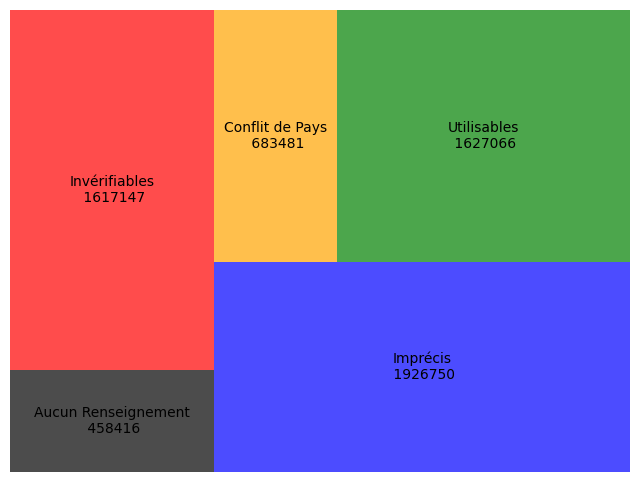

In [39]:
# TreeMap de l'évaluation des données
geosra_pd["eval_data"] = 'Utilisable'
condition_NR  = (geosra_pd["has_latlon"].isnull()) & (geosra_pd["geo_loc_name_country_calc"].isnull()) & (geosra_pd["rg_country"] == '')
condition_INV = (geosra_pd["has_latlon"].isnull()) & ((geosra_pd["geo_loc_name_country_calc"] != 'uncalculated') | (geosra_pd["rg_country"] != '') | (geosra_pd["geo_loc_name_country_calc"].notnull()))
condition_IMP = ((geosra_pd["has_latlon"].notnull()) & ((geosra_pd["latitude_precision"] <= 2) | (geosra_pd["longitude_precision"] <= 2)))
condition_CON = (geosra_pd["conflict_country"] == True)

geosra_pd.loc[condition_NR, "eval_data"] = 'Aucun Renseignement'
geosra_pd.loc[condition_INV,"eval_data"] = 'Inverifiable'
geosra_pd.loc[condition_IMP,"eval_data"] = 'Imprecis'
geosra_pd.loc[condition_CON,"eval_data"] = 'Conflit Pays'

nb_NR  = len(geosra_pd[condition_NR]) 
nb_INV = len(geosra_pd[condition_INV]) 
nb_IMP = len(geosra_pd[condition_IMP])
nb_CON = len(geosra_pd[condition_CON])
good = len(geosra_pd) - (nb_NR + nb_INV + nb_IMP + nb_CON)

sizes = [nb_NR, nb_INV, nb_IMP, nb_CON, good]
labels = [f"Aucun Renseignement\n {nb_NR}", f"Invérifiables\n {nb_INV}", f"Imprécis\n {nb_IMP}", f"Conflit de Pays\n {nb_CON}", f"Utilisables\n {good}"]
plt.figure(figsize=(8, 6))
squarify.plot(sizes=sizes, label=labels, color=param["TreeMap Color"], alpha=0.7)
plt.axis('off')
plt.show()


In [40]:
# Enregistrement des données potentiellement exploitables
condition_clean = (geosra_pd["eval_data"] != 'Aucun Renseignement')
geosra_propre = geosra_pd[condition_clean]
geosra_propre.to_parquet(param["GeoSRA DIR OUT"])